In [1]:
%matplotlib inline
import nengo
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import lu
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.matplotlib import rasterplot


N=32 # neurons in the hidden layer
dt=1e-4
T=2
seed=666
syn=0.02
k=100

np.random.seed(seed)
A = np.abs(np.random.rand(N,4))
B = np.abs(np.random.rand(1,N))
Apl, Au = lu(A, permute_l=True)

def gen_input(t):
    return (np.ones(4) + [np.sin(4*t), np.sin(4*t-1), np.sin(4*t-2), np.sin(4*t-3)])/2

ntype = nengo.SpikingRectifiedLinear()

with nengo.Network('model') as model:

    # Input node
    node_X = nengo.Node(output=gen_input)
    ens_x = nengo.Ensemble(4, 1, neuron_type=ntype, seed=seed, bias=np.zeros(4), gain=np.ones(4), label='X')
    nengo.Connection(node_X, ens_x.neurons, transform=np.eye(4)*k, synapse=None)
    
    node_Y = nengo.Node(size_in=1)
    node_Y2 = nengo.Node(size_in=1)
    
    # Ax -> P
    P = nengo.Ensemble(N, 1, neuron_type=ntype, seed=seed, bias=np.zeros(N), gain=np.ones(N), label='P')
    nengo.Connection(ens_x.neurons, P.neurons, transform=A, synapse=None)
    nengo.Connection(P.neurons, node_Y, transform=B, synapse=None)

    P_u = nengo.Ensemble(4, 1, neuron_type=ntype, seed=seed, bias=np.zeros(4), gain=np.ones(4), label='P_u')
    P_pl = nengo.Ensemble(N, 1, neuron_type=ntype, seed=seed, bias=np.zeros(N), gain=np.ones(N), label='P_pl')
    nengo.Connection(ens_x.neurons, P_u.neurons, transform=Au, synapse=None)
    nengo.Connection(P_u.neurons, P_pl.neurons, transform=Apl, synapse=None)
    nengo.Connection(P_pl.neurons, node_Y2, transform=B, synapse=None)
    
    # Probes
    probe_X = nengo.Probe(node_X)
    probe_ensX = nengo.Probe(ens_x.neurons, 'spikes')
    probe_ensX_filt = nengo.Probe(ens_x.neurons, 'spikes', synapse=nengo.Alpha(syn))
    probe_Y = nengo.Probe(node_Y, synapse=nengo.Alpha(syn))
    probe_Y2 = nengo.Probe(node_Y2, synapse=nengo.Alpha(syn))
    probe_P = nengo.Probe(P.neurons, 'spikes')
    
with nengo.Simulator(model, dt=dt, seed=seed) as sim:
    sim.run(T)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, '(c)'), Text(0, 0.5, 'Neuron #'), Text(0.5, 0, 'Time [s]')]

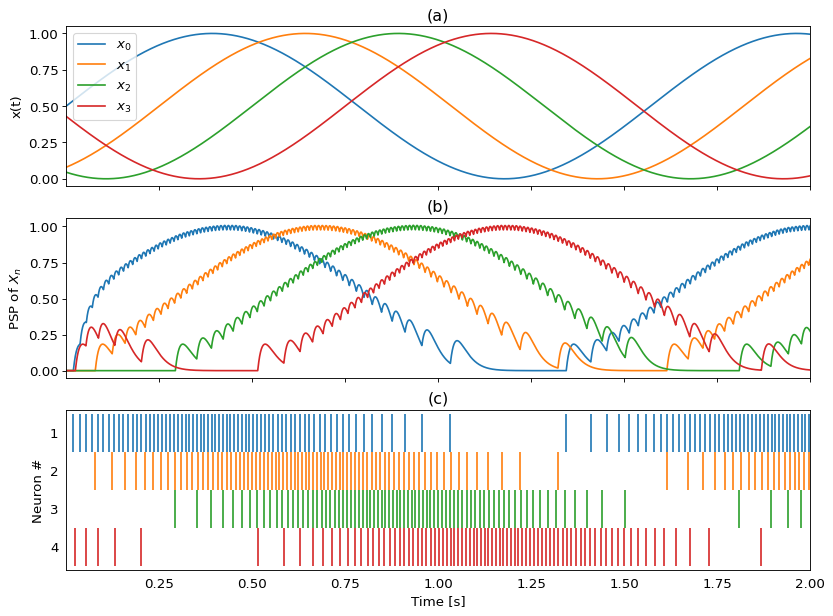

In [2]:
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1,sharex=True,figsize=(12,9),dpi=80)
ax[0].plot(sim.trange(), sim.data[probe_X][:,0], label='$x_0$')
ax[0].plot(sim.trange(), sim.data[probe_X][:,1], label='$x_1$')
ax[0].plot(sim.trange(), sim.data[probe_X][:,2], label='$x_2$')
ax[0].plot(sim.trange(), sim.data[probe_X][:,3], label='$x_3$')
ax[0].set(title="(a)", ylabel='x(t)')
ax[0].legend()

ax[1].plot(sim.trange(), sim.data[probe_ensX_filt]/k)
ax[1].set(title="(b)", ylabel='PSP of $X_n$')

rasterplot(sim.trange(), sim.data[probe_ensX], use_eventplot=True)
ax[2].set(title="(c)", ylabel='Neuron #', xlabel='Time [s]')

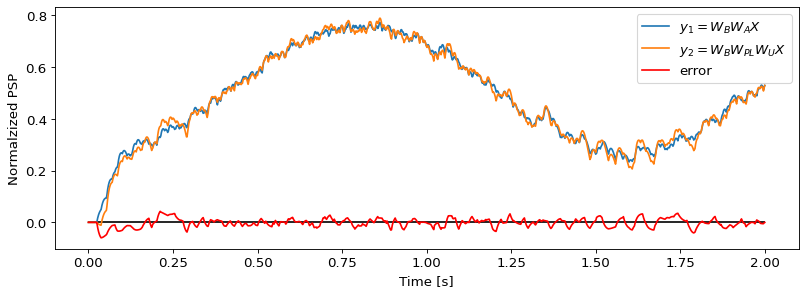

In [3]:
plt.figure(figsize=(12,4), dpi=80)
plt.plot(sim.trange(), sim.data[probe_Y]/(k*N), label='$y_1=W_BW_AX$')
plt.plot(sim.trange(), sim.data[probe_Y2]/(k*N), label='$y_2=W_BW_{PL}W_UX$')
plt.plot(sim.trange(), (sim.data[probe_Y2]-sim.data[probe_Y])/(k*N), label='error', color='red')
plt.hlines(0, xmin=0, xmax=T, color='black')
plt.xlabel('Time [s]')
plt.ylabel('Normalzized PSP')
plt.legend()
plt.show()

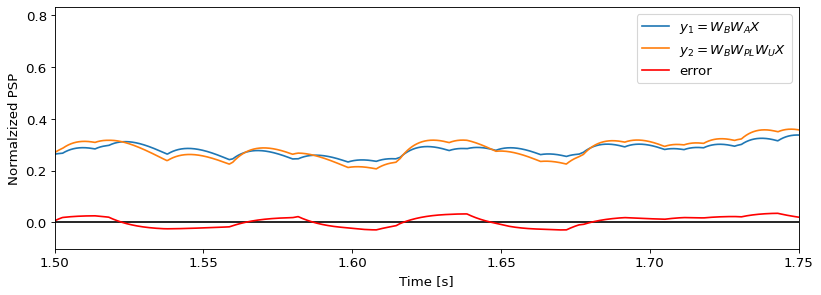

In [4]:
plt.figure(figsize=(12,4), dpi=80)
plt.plot(sim.trange(), sim.data[probe_Y]/(k*N), label='$y_1=W_BW_AX$')
plt.plot(sim.trange(), sim.data[probe_Y2]/(k*N), label='$y_2=W_BW_{PL}W_UX$')
error = (sim.data[probe_Y2]-sim.data[probe_Y])/(k*N)
plt.plot(sim.trange(), error, label='error', color='red')
plt.hlines(0, xmin=0, xmax=T, color='black')
plt.xlabel('Time [s]')
plt.ylabel('Normalzized PSP')
plt.xlim(1.5,1.75)
plt.legend()
plt.show()

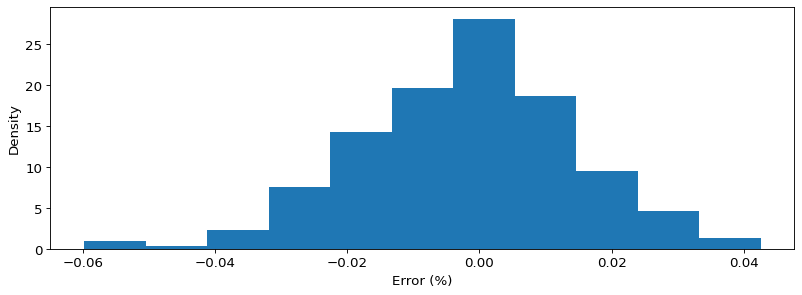

In [5]:
plt.figure(figsize=(12,4), dpi=80)
plt.hist(error,bins=11,density=True)
plt.xlabel('Error (%)')
plt.ylabel('Density')
plt.show()

In [6]:
quartiles = np.percentile(error, [1,10,50,90,99])
print('error [1%,10%,50%,90%,99%] quartiles: ' + str(quartiles))
print('mean error: ' + str(np.mean(error)))

error [1%,10%,50%,90%,99%] quartiles: [-0.04806383 -0.02291999 -0.00061335  0.01761447  0.0338342 ]
mean error: -0.002024525694145931


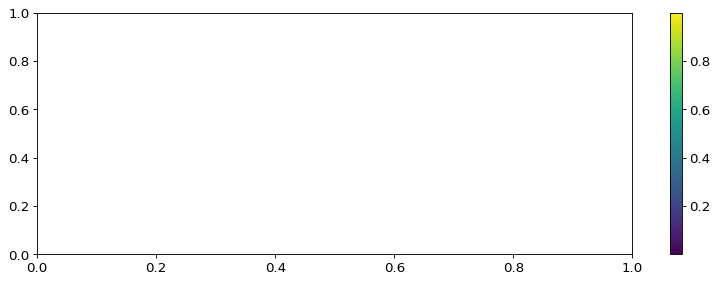

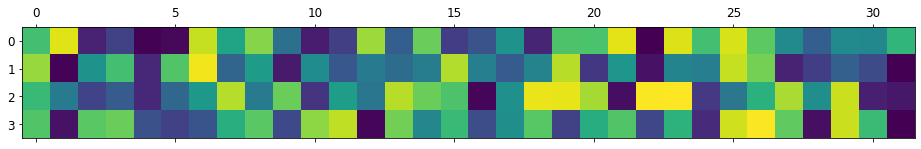

In [7]:
fig = plt.figure(figsize=(12,4), dpi=80)
mat_a = plt.matshow(np.transpose(A))

<Figure size 960x320 with 0 Axes>

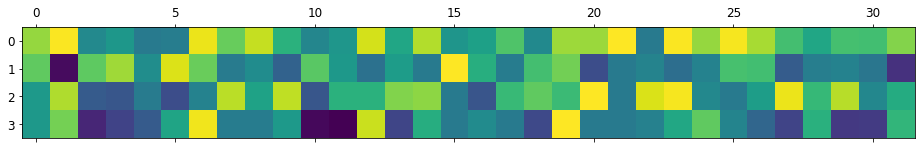

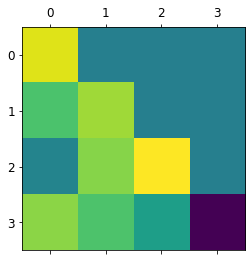

In [8]:
plt.figure(figsize=(12,4), dpi=80)
mat_pl=plt.matshow(np.transpose(Apl))
mat_u=plt.matshow(np.transpose(Au))
plt.show()